In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GRU, Bidirectional, LeakyReLU

from scipy import stats
%matplotlib inline




In [2]:
#Give access to your google drive account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read dataset into dataframe from the google drive
df=pd.read_csv("/content/drive/MyDrive/GoogleClusterDataset/borg_traces_data.csv")


In [4]:
#Check details of attributes and records in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       405894 non-null  int64  
 1   time                             405894 non-null  int64  
 2   instance_events_type             405894 non-null  int64  
 3   collection_id                    405894 non-null  int64  
 4   scheduling_class                 405894 non-null  int64  
 5   collection_type                  405894 non-null  int64  
 6   priority                         405894 non-null  int64  
 7   alloc_collection_id              405894 non-null  int64  
 8   instance_index                   405894 non-null  int64  
 9   machine_id                       405894 non-null  int64  
 10  resource_request                 405120 non-null  object 
 11  constraint                       405894 non-null  object 
 12  co

In [5]:
df[['cycles_per_instruction', 'memory_accesses_per_instruction']]

,cycles_per_instruction,memory_accesses_per_instruction
0,NaN,NaN
1,NaN,NaN
2,0.939919,0.001318
3,1.359102,0.007643
4,NaN,NaN
...,...,...
405889,0.693324,0.003158
405890,1.019433,0.001859
405891,0.990970,0.002941
405892,3.023431,0.015743


In [6]:
#Drop the columns
df.drop(['cycles_per_instruction', 'memory_accesses_per_instruction'], axis=1, inplace=True)

Splitting resource request column into two columns- cpu_resource_request and memory_resource_request

In [7]:
df[['cpu', 'memory']] = df['resource_request'].str.split(',', expand=True)

df[['cpu_dummy', 'cpu_resource_request']] = df['cpu'].str.split(':', expand=True)

df[['memory_dummy', 'memory_resource_request']] = df['memory'].str.split(':', expand=True)



In [8]:
df.drop(['cpu', 'memory','cpu_dummy','memory_dummy','resource_request'], axis=1,inplace=True)

df['memory_resource_request'] = df['memory_resource_request'].str[:-1]

#Converting values in the columns "memory_resource_request" and "cpu_resource_request" into float type
df['memory_resource_request'] = df['memory_resource_request'].astype(float)
df['cpu_resource_request'] = df['cpu_resource_request'].astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   405894 non-null  int64  
 1   time                         405894 non-null  int64  
 2   instance_events_type         405894 non-null  int64  
 3   collection_id                405894 non-null  int64  
 4   scheduling_class             405894 non-null  int64  
 5   collection_type              405894 non-null  int64  
 6   priority                     405894 non-null  int64  
 7   alloc_collection_id          405894 non-null  int64  
 8   instance_index               405894 non-null  int64  
 9   machine_id                   405894 non-null  int64  
 10  constraint                   405894 non-null  object 
 11  collections_events_type      405894 non-null  int64  
 12  user                         405894 non-null  object 
 13 

Splitting 'average_usage' column into two columns- cpu_avg_usage and memory_avg_usage

In [10]:
df[['cpu', 'memory']] = df['average_usage'].str.split(',', expand=True)

df[['cpu_dummy', 'cpu_avg_usage']] = df['cpu'].str.split(':', expand=True)

df[['memory_dummy', 'memory_avg_usage']] = df['memory'].str.split(':', expand=True)

#Drop the intermediate columns which are not useful
df.drop(['cpu', 'memory','cpu_dummy','memory_dummy','average_usage'], axis=1,inplace=True)

df['memory_avg_usage'] = df['memory_avg_usage'].str[:-1]

#Converting values in the columns 'memory_avg_usage' and 'cpu_avg_usage' from string type to float types
df['memory_avg_usage'] = df['memory_avg_usage'].astype(float)
df['cpu_avg_usage'] = df['cpu_avg_usage'].astype(float)

Splitting 'maximum_usage' into 'cpu_max_usage' and 'memory_max_usage'

In [11]:
df[['cpu', 'memory']] = df['maximum_usage'].str.split(',', expand=True)

df[['cpu_dummy', 'cpu_max_usage']] = df['cpu'].str.split(':', expand=True)

df[['memory_dummy', 'memory_max_usage']] = df['memory'].str.split(':', expand=True)

#Drop the intermediate columns which are not useful
df.drop(['cpu', 'memory','cpu_dummy','memory_dummy','maximum_usage'], axis=1,inplace=True)

df['memory_max_usage'] = df['memory_max_usage'].str[:-1]

#Converting values in the columns 'memory_avg_usage' and 'cpu_avg_usage' from string type to float types
# Replace 'none' with '0' and convert the column to float
df['memory_max_usage'] = df['memory_max_usage'].replace(' None', '0').astype(float)
#df['memory_max_usage'] = df['memory_max_usage'].astype(float)
df['cpu_max_usage'] = df['cpu_max_usage'].astype(float)

In [12]:
#Splitting column 'cpu_usage_distribution' and removing "[" and "]" from the string and storing in "cpu_usage_distribution"
df[['cpu', 'memory']] = df['cpu_usage_distribution'].str.split('[', expand=True)

df[['cpu_usage_distribution', 'memory_random_sample_usage']] = df['memory'].str.split(']', expand=True)


#Drop the intermediate columns which are not useful
df.drop(['cpu', 'memory','memory_random_sample_usage'], axis=1,inplace=True)

df['cpu_usage_distribution'] = df['cpu_usage_distribution'].str[:-1]

#convert string to float in column "cpu_usage_distribution"
df['cpu_usage_distribution'] = df['cpu_usage_distribution'].str.split().apply(lambda x: [float(val) for val in x])

In [13]:
#Splitting column 'tail_cpu_usage_distribution' and removing "[" and "]" from the string and storing in "tail_cpu_usage_distribution"
df[['cpu', 'memory']] = df['tail_cpu_usage_distribution'].str.split('[', expand=True)

df[['tail_cpu_usage_distribution', 'memory_random_sample_usage']] = df['memory'].str.split(']', expand=True)

#Drop the intermediate columns which are not useful
df.drop(['cpu', 'memory','memory_random_sample_usage'], axis=1,inplace=True)

df['tail_cpu_usage_distribution'] = df['tail_cpu_usage_distribution'].str[:-1]

#convert string to float in column "tail_cpu_usage_distribution"
df['tail_cpu_usage_distribution'] = df['tail_cpu_usage_distribution'].str.split().apply(lambda x: [float(val) for val in x])

In [14]:
# creating a blank series
priority_new = []

# running a for loop and assigning some values to series
for i in range(len(df)):
  if df['priority'][i] in range (0, 100):
    priority_new.append(0)
  elif df["priority"][i] in range (100,116):
    priority_new.append(1)
  elif df["priority"][i] in range (116,120):
    priority_new.append(2)
  elif df["priority"][i] in range (120,360):
    priority_new.append(3)
  else:
    priority_new.append(4)


# inserting new column with values of list made above
#df.insert(7, "new_priority", priority_new)

# list output
#data.head()

In [15]:
df.drop("priority", axis=1, inplace=True)

In [16]:
# inserting new column with values of list made above
df.insert(2, "priority", priority_new)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   405894 non-null  int64  
 1   time                         405894 non-null  int64  
 2   priority                     405894 non-null  int64  
 3   instance_events_type         405894 non-null  int64  
 4   collection_id                405894 non-null  int64  
 5   scheduling_class             405894 non-null  int64  
 6   collection_type              405894 non-null  int64  
 7   alloc_collection_id          405894 non-null  int64  
 8   instance_index               405894 non-null  int64  
 9   machine_id                   405894 non-null  int64  
 10  constraint                   405894 non-null  object 
 11  collections_events_type      405894 non-null  int64  
 12  user                         405894 non-null  object 
 13 

In [18]:
df['tail_cpu_usage_distribution']

0         [0.00535583, 0.00541687, 0.00548553, 0.0055465...
1         [1.23977661e-05, 1.23977661e-05, 1.23977661e-0...
2         [0.02902222, 0.02929688, 0.0295105, 0.0296936,...
3         [0.05535889, 0.05584717, 0.05633545, 0.0571899...
4         [0.00041485, 0.00041485, 0.00041485, 0.0004148...
                                ...                        
405889    [0.0222168, 0.02261353, 0.02294922, 0.02404785...
405890    [0.05828857, 0.05871582, 0.05938721, 0.0609741...
405891    [0.03515625, 0.03552246, 0.03729248, 0.0391235...
405892    [0.00904846, 0.00907898, 0.00909424, 0.0091247...
405893    [0.01922607, 0.02011108, 0.02130127, 0.0220642...
Name: tail_cpu_usage_distribution, Length: 405894, dtype: object

In [19]:
df.head()

,Unnamed: 0,time,priority,instance_events_type,collection_id,scheduling_class,collection_type,alloc_collection_id,instance_index,machine_id,...,tail_cpu_usage_distribution,cluster,event,failed,cpu_resource_request,memory_resource_request,cpu_avg_usage,memory_avg_usage,cpu_max_usage,memory_max_usage
0,0,0,3,2,94591244395,3,1,0,144,168846390496,...,"[0.00535583, 0.00541687, 0.00548553, 0.0055465...",7,FAIL,1,0.020660,0.014435,0.004662,5.920410e-03,0.011902,5.935669e-03
1,1,2517305308183,4,2,260697606809,2,0,221495397286,335,85515092,...,"[1.23977661e-05, 1.23977661e-05, 1.23977661e-0...",7,FAIL,1,0.007240,0.001303,0.000000,9.536743e-07,0.000000,9.536743e-07
2,2,195684022913,1,6,276227177776,2,0,0,376,169321752432,...,"[0.02902222, 0.02929688, 0.0295105, 0.0296936,...",7,SCHEDULE,0,0.048584,0.004166,0.024200,2.788544e-03,0.060059,2.845764e-03
3,3,0,3,2,10507389885,3,0,0,1977,178294817221,...,"[0.05535889, 0.05584717, 0.05633545, 0.0571899...",8,FAIL,1,0.070435,0.041626,0.047607,3.442383e-02,0.133301,3.466797e-02
4,4,1810627494172,0,3,25911621841,2,0,0,3907,231364893292,...,"[0.00041485, 0.00041485, 0.00041485, 0.0004148...",2,FINISH,0,0.002449,0.000232,0.000271,7.629395e-05,0.000415,7.629395e-05


In [20]:
#Encode the column 'user' from string to integer

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the string labels and transform them to float labels
df['user'] = label_encoder.fit_transform(df['user'])
df['user']

0         612
1         218
2          30
3         149
4           6
         ... 
405889    672
405890    218
405891     19
405892    672
405893    218
Name: user, Length: 405894, dtype: int64

In [21]:
df['event'] = label_encoder.fit_transform(df['event'])

In [22]:
#Drop the intermediate columns which are not useful
df.drop(['cpu_usage_distribution','tail_cpu_usage_distribution'], axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  405894 non-null  int64  
 1   time                        405894 non-null  int64  
 2   priority                    405894 non-null  int64  
 3   instance_events_type        405894 non-null  int64  
 4   collection_id               405894 non-null  int64  
 5   scheduling_class            405894 non-null  int64  
 6   collection_type             405894 non-null  int64  
 7   alloc_collection_id         405894 non-null  int64  
 8   instance_index              405894 non-null  int64  
 9   machine_id                  405894 non-null  int64  
 10  constraint                  405894 non-null  object 
 11  collections_events_type     405894 non-null  int64  
 12  user                        405894 non-null  int64  
 13  collection_nam

In [24]:
 #Drop the intermediate columns which are not useful
df.drop(['constraint', 'collection_name','collection_logical_name',
         'start_after_collection_ids','random_sample_usage'], axis=1, inplace=True)


In [25]:
# Remove rows with NaN values
df = df.dropna()

In [26]:
df

,Unnamed: 0,time,priority,instance_events_type,collection_id,scheduling_class,collection_type,alloc_collection_id,instance_index,machine_id,...,sample_rate,cluster,event,failed,cpu_resource_request,memory_resource_request,cpu_avg_usage,memory_avg_usage,cpu_max_usage,memory_max_usage
0,0,0,3,2,94591244395,3,1,0,144,168846390496,...,1.000000,7,2,1,0.020660,0.014435,0.004662,5.920410e-03,0.011902,5.935669e-03
1,1,2517305308183,4,2,260697606809,2,0,221495397286,335,85515092,...,1.000000,7,2,1,0.007240,0.001303,0.000000,9.536743e-07,0.000000,9.536743e-07
2,2,195684022913,1,6,276227177776,2,0,0,376,169321752432,...,1.000000,7,7,0,0.048584,0.004166,0.024200,2.788544e-03,0.060059,2.845764e-03
3,3,0,3,2,10507389885,3,0,0,1977,178294817221,...,1.000000,8,2,1,0.070435,0.041626,0.047607,3.442383e-02,0.133301,3.466797e-02
4,4,1810627494172,0,3,25911621841,2,0,0,3907,231364893292,...,1.000000,2,3,0,0.002449,0.000232,0.000271,7.629395e-05,0.000415,7.629395e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405889,405889,0,2,2,299950285958,1,0,0,1341,10625460233,...,1.000000,8,2,1,0.035950,0.015488,0.015320,1.501083e-03,0.048340,1.802444e-03
405890,405890,18279167039,4,0,330587213089,2,0,330587120885,898,68669881389,...,1.000000,1,0,0,0.021973,0.001303,0.038147,1.998901e-02,0.091797,2.047729e-02
405891,405891,733307641549,3,3,13748637767,3,0,13748635759,1959,126641993288,...,1.000000,2,3,0,0.121460,0.082642,0.023560,7.580566e-02,0.062500,7.580566e-02
405892,405892,1984523129238,2,2,323372663325,1,0,0,6452,191941429308,...,0.996667,8,2,1,0.005669,0.001562,0.006004,9.822845e-04,0.018433,1.380920e-03


Separate features (X) and target variable (y)

In [27]:
# Separate features (X) and target variable (y)
X = df.drop("failed", axis=1) # Features
y = df["failed"]              # Target

In [28]:
y.shape

(404161,)

In [29]:
X.shape

(404161, 27)

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have a dataset 'data' and corresponding labels 'labels'

# Split the data into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now, you have X_train, y_train for training, X_val, y_val for validation, and X_test, y_test for testing.


SVM

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.svm import SVC  # For classification problems
# from sklearn.svm import SVR  # For regression problems

# Create the SVM model
svm_model = SVC(kernel='linear', C=1.0, max_iter=10)

# Train the model
svm_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=10)

In [33]:
y_pred = svm_model.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.25230515463917524
              precision    recall  f1-score   support

           0       0.95      0.03      0.07     46842
           1       0.23      0.99      0.38     13783

    accuracy                           0.25     60625
   macro avg       0.59      0.51      0.22     60625
weighted avg       0.79      0.25      0.14     60625



Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

# Create the Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [36]:
y_pred1 = logreg_model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred1)
report = classification_report(y_test, y_pred1)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.7665649484536082
              precision    recall  f1-score   support

           0       0.79      0.96      0.86     46842
           1       0.45      0.12      0.19     13783

    accuracy                           0.77     60625
   macro avg       0.62      0.54      0.52     60625
weighted avg       0.71      0.77      0.71     60625



ANN

In [38]:
# Building ANN Model
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))


In [39]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3905 (15.25 KB)
Trainable params: 3905 (15.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
8841/8841 [==============================] - 33s 3ms/step - loss: 0.0149 - accuracy: 0.9937
Epoch 2/10
8841/8841 [==============================] - 30s 3ms/step - loss: 9.6167e-05 - accuracy: 1.0000
Epoch 3/10
8841/8841 [==============================] - 28s 3ms/step - loss: 8.7552e-05 - accuracy: 1.0000
Epoch 4/10
8841/8841 [==============================] - 28s 3ms/step - loss: 5.5052e-08 - accuracy: 1.0000
Epoch 5/10
8841/8841 [==============================] - 27s 3ms/step - loss: 3.7242e-09 - accuracy: 1.0000
Epoch 6/10
8841/8841 [==============================] - 27s 3ms/step - loss: 5.3242e-05 - accuracy: 1.0000
Epoch 7/10
8841/8841 [==============================] - 27s 3ms/step - loss: 6.5370e-05 - accuracy: 1.0000
Epoch 8/10
8841/8841 [==============================] - 28s 3ms/step - loss: 6.9697e-08 - accuracy: 1.0000
Epoch 9/10
8841/8841 [==============================] - 27s 3ms/step - loss: 1.8213e-10 - accuracy: 1.0000
Epoch 10/10
8841/8841 [==================

In [42]:
y_pred2 = model.predict(X_test)

1895/1895 [==============================] - 3s 2ms/step


In [43]:
# Evaluate the model

from sklearn.metrics import accuracy_score, classification_report

# Convert predictions to binary values if needed (e.g., for binary classification)
y_pred_binary = (y_pred2 > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46842
           1       1.00      1.00      1.00     13783

    accuracy                           1.00     60625
   macro avg       1.00      1.00      1.00     60625
weighted avg       1.00      1.00      1.00     60625



CNN

In [44]:
X_train.shape

(282912, 27)

In [45]:
X_test.shape

(60625, 27)

In [46]:
y_train.shape

(282912,)

In [47]:
y_test.shape

(60625,)

In [48]:
# Reshape the data. It should be in 3D format
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [49]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(27, 1)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

In [50]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
# Print a summary of the model architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                24640     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 24898 (97.26 KB)
Trainable params: 24898 (97.26 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [52]:
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
8841/8841 [==============================] - 39s 4ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 711561314304.0000 - val_accuracy: 0.3113
Epoch 2/10
8841/8841 [==============================] - 35s 4ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 567257530368.0000 - val_accuracy: 0.6492
Epoch 3/10
8841/8841 [==============================] - 34s 4ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 911426781184.0000 - val_accuracy: 0.2986
Epoch 4/10
8841/8841 [==============================] - 34s 4ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 463208513536.0000 - val_accuracy: 0.6667
Epoch 5/10
8841/8841 [==============================] - 34s 4ms/step - loss: 3.5158e-04 - accuracy: 0.9999 - val_loss: 513546289152.0000 - val_accuracy: 0.3309
Epoch 6/10
8841/8841 [==============================] - 34s 4ms/step - loss: 7.7590e-04 - accuracy: 0.9999 - val_loss: 760843141120.0000 - val_accuracy: 0.6620
Epoch 7/10
8841/8841 [==============================] - 

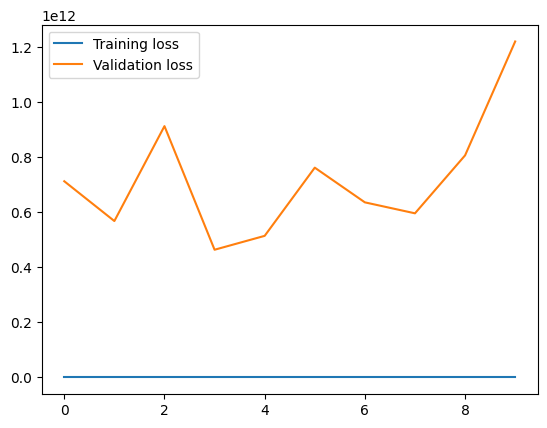

In [53]:
#Plot a curve showing training loss vs validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

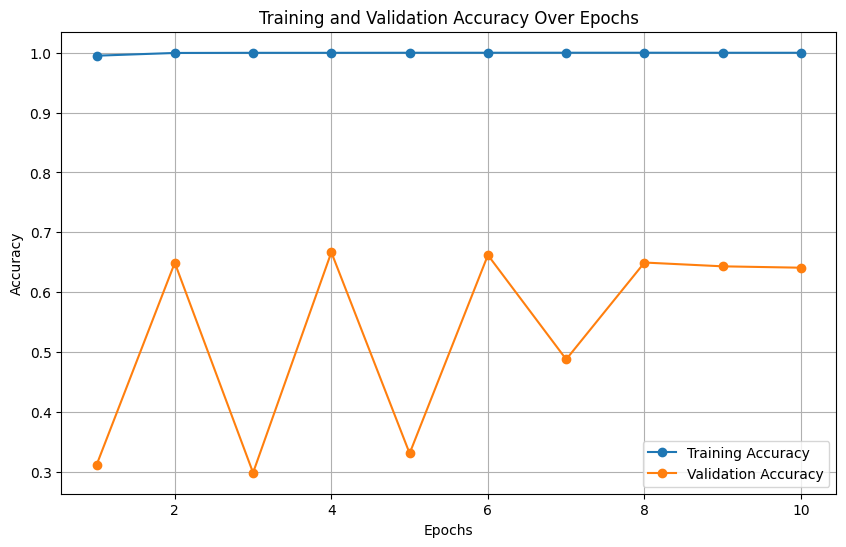

In [54]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
epochs = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10]  # Number of epochs
#training_accuracy = [0.6, 0.7, 0.75, 0.8, 0.85]  # Training accuracy values
#validation_accuracy = [0.55, 0.65, 0.7, 0.75, 0.78]  # Validation accuracy values
#epochs=10
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], marker='o', label='Validation Accuracy')

# Add labels and a legend
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [55]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

1895/1895 [==============================] - 5s 3ms/step - loss: 2.1834e-06 - accuracy: 1.0000
Test accuracy: 1.0


In [56]:
predictions = model.predict(X_test)

1895/1895 [==============================] - 4s 2ms/step


In [57]:
# Evaluate the model with additional metrics if needed
from sklearn.metrics import classification_report

# Assuming your labels are one-hot encoded, you may need to convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels for comparison
#true_classes = np.argmax(y_test)

accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print(classification_report(y_test, predicted_classes))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46842
           1       1.00      1.00      1.00     13783

    accuracy                           1.00     60625
   macro avg       1.00      1.00      1.00     60625
weighted avg       1.00      1.00      1.00     60625



ROC Curve of comparison

In [58]:
from sklearn.metrics import roc_curve

#SVM
# Assuming y_test contains true labels and y_pred contains predicted scores
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)


In [59]:
#Logistic Regression
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred1)

In [60]:
#ANN
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_binary)

In [61]:
#CNN
fpr4, tpr4, thresholds4 = roc_curve(y_test, predicted_classes)

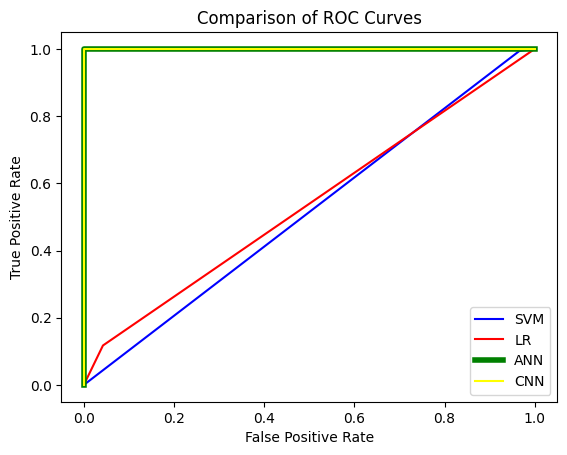

In [65]:
import matplotlib.pyplot as plt

# Plot individual ROC curves (replace with your data)
plt.plot(fpr1, tpr1, label='SVM', color='blue')
plt.plot(fpr2, tpr2, label='LR', color='red')
plt.plot(fpr3, tpr3, linewidth=4, label='ANN', color='green')
plt.plot(fpr4, tpr4, label='CNN', color='yellow')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend()
plt.show()


In [63]:
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr))) # You need to calculate AUC
plt.plot([0, 1], [0, 1], 'k--')  # 45-degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, label=\'ROC curve (AUC = {:.2f})\'.format(auc(fpr, tpr))) # You need to calculate AUC\nplt.plot([0, 1], [0, 1], \'k--\')  # 45-degree line\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic (ROC) Curve\')\nplt.legend(loc="lower right")\nplt.show()\n'

In [64]:
#This is an example for plotting a ROC curve
'''
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for demonstration
np.random.seed(42)
y_true = np.random.randint(0, 2, 100)
y_scores = np.random.rand(100)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
'''


'\nfrom sklearn.metrics import roc_curve, auc\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate random data for demonstration\nnp.random.seed(42)\ny_true = np.random.randint(0, 2, 100)\ny_scores = np.random.rand(100)\n\nfpr, tpr, thresholds = roc_curve(y_true, y_scores)\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, label=\'ROC curve (AUC = {:.2f})\'.format(auc(fpr, tpr)))\nplt.plot([0, 1], [0, 1], \'k--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic (ROC) Curve\')\nplt.legend(loc="lower right")\nplt.show()\n'